# Plotting comparison plots Homo-PSI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from data_cleaner import load_full_df, create_individual_dfs, read_json_bench

### Config style

In [3]:
sns.set_style()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('figure', figsize=(5.5,4))
plt.rc('text.latex', preamble=r'\usepackage{mathptmx}')

FIG_DIR = ''

### Load data

In [4]:
create_individual_dfs('../data/raw/', '../data/agg/')

In [18]:
data = load_full_df('../data/',  ['circuit_psi', 'emp_x', 'emp_ca', 'spot'])
data = data.query('SetNum > 4')

# Add artificial network delay to our X-MS and CA-MS data
adj_indx = data.query('name in ["CA-MS", "X-MS"]').index
data.loc[adj_indx,'Latency'] += 0.1 # add 1 rtt 
data.loc[adj_indx,'Latency'] += data.loc[adj_indx,'com_MiB'] / (100/8)# add transfer cost

## Plot base

In [6]:
main_plot_config = {
    'CA-MS':{
        'label':"CA-Agg $(P_{8k})$",
        'color':'#33a02c',
        'fmt':'*-'
    },
    'X-MS':{
        'label':"X-Agg $(P_{32k})$",
        'color':'#b2df8a',
        'fmt':'o:'
    },
    'EMP-CA':{
        'label':"CA-EMP",
        'color':'#1f78b4',
        'fmt':'*-'
    },
    'EMP-X':{
        'label':"X-EMP",
        'color':'#a6cee3',
        'fmt':'o:'
    },
    'Circuit-PSI':{
        'label':"Circuit-PSI",
        'color':'#e31a1c',
        'fmt':'x-.'
    },
}
spot_plot_config = {
    'CA-MS':{
        'label':"CA-Agg $(P_{8k})$",
        'color':'#33a02c',
        'fmt':'*-'
    },
    'X-MS':{
        'label':"X-Agg $(P_{32k})$",
        'color':'#b2df8a',
        'fmt':'o:'
    },
    'SpOT':{
        'label':"SpOT",
        'color':'#e31a1c',
        'fmt':'x-.'
    },
    # 
}

In [7]:
def base_plot(
    ax:plt.Axes,
    df: pd.DataFrame,
    target_y:str,
    y_label:str,
    config: dict[str:str],
    ):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('\#Documents')
    ax.set_ylabel(y_label)
    major_ticks = [8, 32, 128, 512, 2048, 8192]
    ax.set_xticks(major_ticks, major_ticks)
    minor_ticks = [16, 64, 256, 1024, 4096]
    ax.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    df = df.groupby(['SetNum', 'name']).agg(['mean', 'sem'])
    df = df.reset_index()

    for name in config:
        # print(plot_config[name])
        df_fil = df[df['name'] == name]
        x , y, yerr = df_fil["SetNum"], df_fil[target_y,'mean'], df_fil[target_y,'sem']
        ax.errorbar(x, y, yerr=yerr, linewidth=2, **config[name])

    


### Latency

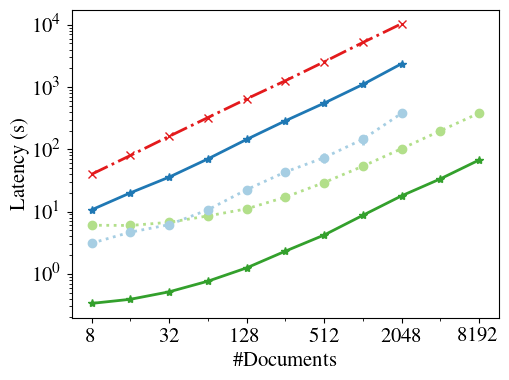

In [8]:
fig, ax = plt.subplots()
base_plot(ax, data, 'Latency', 'Latency (s)', main_plot_config)

plt.savefig(FIG_DIR+"doc_latency.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

### Client computation

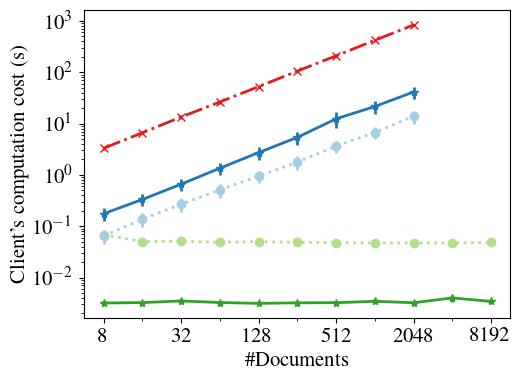

In [9]:
fig, ax = plt.subplots()
ylabel = "Client's computation cost (s)"
base_plot(ax, data, 'client_comp', ylabel, main_plot_config)

plt.savefig(FIG_DIR+"doc_client.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

### Communication

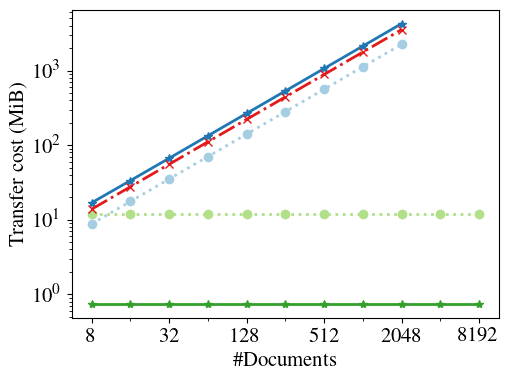

In [10]:
fig, ax = plt.subplots()
ylabel = "Transfer cost (MiB)"
base_plot(ax, data, 'com_MiB', ylabel, main_plot_config)

plt.savefig(FIG_DIR+"doc_com.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

### Server cost

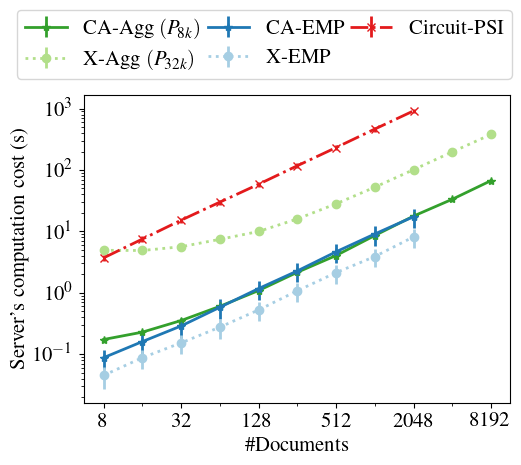

In [11]:
fig, ax = plt.subplots()
ylabel = "Server's computation cost (s)"
base_plot(ax, data, 'server_comp', ylabel, main_plot_config)
ax.legend(
    bbox_to_anchor=(0.002, 0.92, 0.9, .102), 
    loc='lower left',
    ncol=3, 
    mode="expand", 
    borderaxespad=0., 
    bbox_transform=fig.transFigure,
)
plt.savefig(FIG_DIR+"doc_server.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

## triple plot 

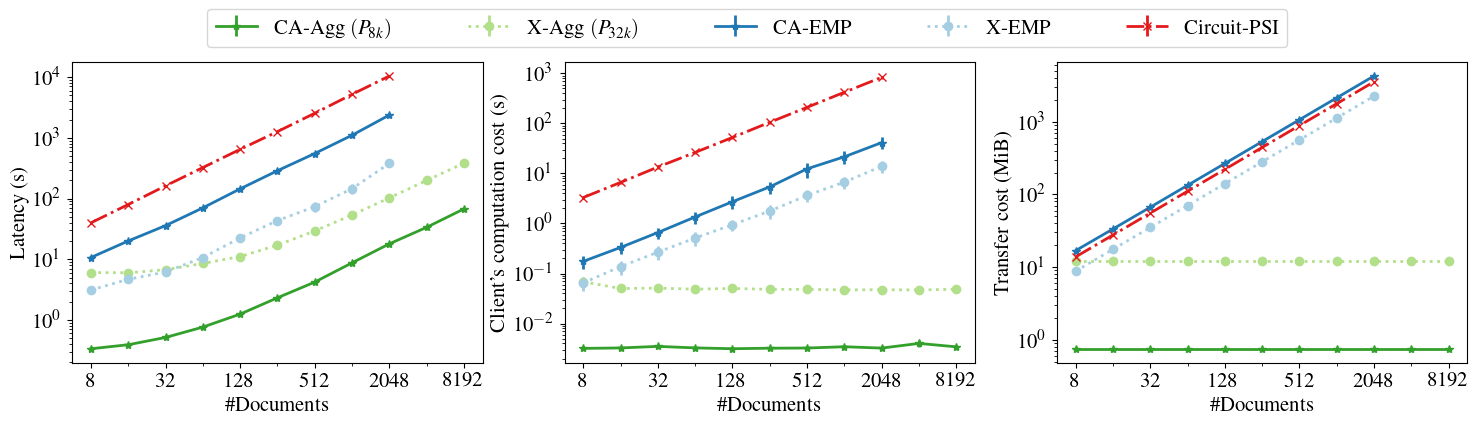

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18,3.9))
axes = axes.flat

base_plot(axes[0], data, 'Latency', 'Latency (s)', main_plot_config)
base_plot(axes[2], data, 'com_MiB', "Transfer cost (MiB)", main_plot_config)
base_plot(axes[1], data, 'client_comp', "Client's computation cost (s)", main_plot_config)

handles, labels = axes[0].get_legend_handles_labels()
order = [0,2,1,3,4]
new_handles, new_labels = [handles[idx] for idx in order],[labels[idx] for idx in order]

axes[0].legend(
               # handles=new_handles, labels=new_labels,
               bbox_to_anchor=(0.2, 0.92, 0.60, .102), 
               loc='lower left',
               ncol=5, 
               mode="expand", 
               borderaxespad=0., 
               bbox_transform=fig.transFigure,
              )

plt.savefig(FIG_DIR+"doc_search.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

## SpOT plot

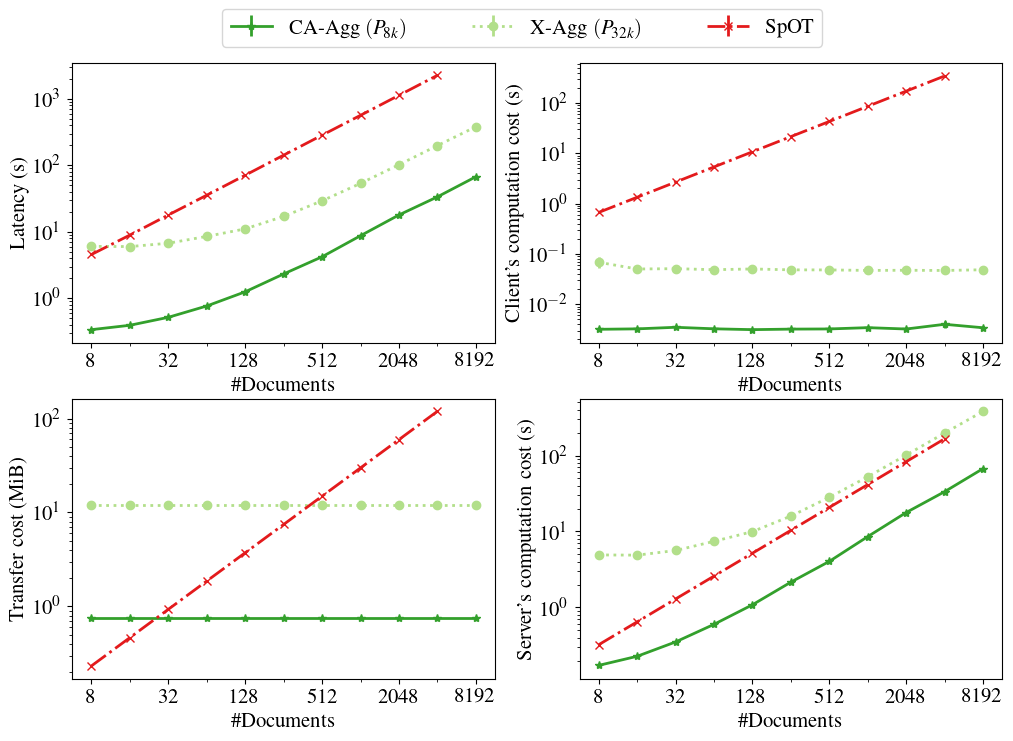

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

base_plot(axes[0][0], data, 'Latency', 'Latency (s)', spot_plot_config)
base_plot(axes[0][1], data, 'client_comp', "Client's computation cost (s)", spot_plot_config)
base_plot(axes[1][1], data, 'server_comp', "Server's computation cost (s)", spot_plot_config)
base_plot(axes[1][0], data, 'com_MiB', "Transfer cost (MiB)", spot_plot_config)

axes[0][0].legend(
               bbox_to_anchor=(0.25, 0.90, 0.50, .102), 
               loc='lower left',
               ncol=3, 
               mode="expand", 
               borderaxespad=0., 
               bbox_transform=fig.transFigure,
              )

plt.savefig(FIG_DIR+"doc_spot.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show() 

## Chemical figures

### Load data

In [14]:
chem_ca_agg = read_json_bench('../data/agg/pcm_chem_ca_agg.json')
chem_x_agg =  read_json_bench('../data/agg/pcm_chem_x_agg.json')
chem_ca_agg['system'] = 'CA'
chem_x_agg['system'] = 'X'

chem_data = pd.concat([chem_x_agg, chem_ca_agg])
chem_data = chem_data.query('SetNum > 2000')
chem_data = chem_data[['SetNum', 'Response', 'RespSize', 'system']]
chem_data = chem_data.groupby(['SetNum', 'system']).agg(['mean', 'sem'])
chem_data = chem_data.reset_index()

### Plot

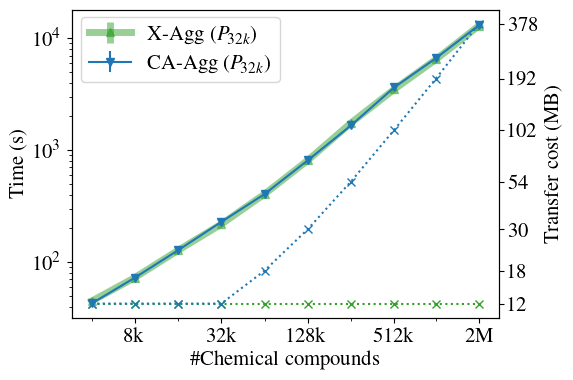

In [15]:
def plot_chem_search(df):
    fig, ax = plt.subplots()

    format = {
        'CA' : {
            'label':"CA-Agg ($P_{32k}$)",
            'color':'#1f78b4',
            'fmt':'v-',
        },
        'X' : {
            'label':"X-Agg ($P_{32k}$)",
            'color':'#33a02c',
            'fmt':'^-',
            'alpha':0.5,
            'linewidth':5,
        },
        'CA-tr' : {
            'label':"CA-MS",
            'color':'#1f78b4',
            'fmt':'x',
            'linestyle':'dotted', 
        },
        'X-tr' : {
            'label':"X-MS",
            'color':'#33a02c',
            'fmt':'x',
            'linestyle':'dotted', 
        }
    }

    ax.set_yscale('log')
    ax.set_ylabel('Time (s)')
    plt.xscale('log')
    ax.set_xlabel('\#Chemical compounds')

    xticks = [2000, 8000, 32000, 128000, 512000, 2000000]
    xminorticks = [4000, 16000, 64000, 256000, 1000000]
    xlabels = [f"{x//1000}k" for x in xticks[:-1]] + ['2M']
    plt.xticks(xticks, xlabels)
    ax.xaxis.set_minor_locator(plt.FixedLocator(xminorticks))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())

    

    ax2 = ax.twinx()
    ax2.set_ylabel('Transfer cost (MB)')
    ax2.set_yscale('log')
    yticks = [12,18,30,54, 102, 192, 378]
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(yticks)
    ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda y, _: ''))
    ax2.get_yaxis().set_tick_params(which='minor', size=0)
    ax2.get_yaxis().set_tick_params(which='minor', width=0) 



    df_fil = df[df['system']=='X']
    x , y, yerr = df_fil["SetNum"], df_fil['Response','mean'], df_fil['Response','sem']
    ax.errorbar(x, y, yerr=yerr, **format['X'])
    x , y = df_fil["SetNum"], df_fil['RespSize','mean']
    y = [a/1024 + 6 for a in y] # Adding 6 MB for the query size 
    ax2.errorbar(x, y, **format['X-tr'])


    df_fil = df[df['system']=='CA']
    x , y, yerr = df_fil["SetNum"], df_fil['Response','mean'], df_fil['Response','sem']
    ax.errorbar(x, y, yerr=yerr, **format['CA'])
    x , y = df_fil["SetNum"], df_fil['RespSize','mean']
    y = [a/1024 + 6 for a in y] # Adding 6 MB for the query size 
    ax2.errorbar(x, y,  **format['CA-tr'])

    ax.legend(loc=(0.02, 0.765))

    plt.savefig("chem_search.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.savefig("chem_search.png", bbox_inches='tight', pad_inches=0.01)
    plt.show()

plot_chem_search(chem_data)

## Small-domain PSI-CA benchmark figure

### Loading data

In [16]:
# The cost is computed based on the micro benchmark in Ruan et al.
# We apply the cost of preprocess once since it can be reused between different sets
ruan_256 = [{'SetNum':ns, "Cost":30+2.7*ns} for ns in [2**i for i in range(13)]]
ruan_4k = [{'SetNum':ns, "Cost":295+14.9*ns} for ns in [2**i for i in range(13)]]
ruan_256 = pd.DataFrame(ruan_256)
ruan_4k = pd.DataFrame(ruan_4k)
ruan_256['system'] = "ruan_256"
ruan_4k['system'] = "ruan_4k"

sd_256 = read_json_bench(f'../data/agg/7700_sm_ca_256_agg.json')
sd_4k = read_json_bench(f'../data/agg/7700_sm_ca_4k_agg.json')
sd_256['system'] = "SD-256"
sd_4k['system'] = "SD-4k"
sd_256['Cost'] = 1000*(sd_256['Evaluation'] + sd_256['Query'] + sd_256['Response'])
sd_4k['Cost'] = 1000*(sd_4k['Evaluation'] + sd_4k['Query'] + sd_4k['Response'])

data_sd = pd.concat([sd_256, sd_4k, ruan_256, ruan_4k])
data_sd = data_sd.query("SetNum < 2000 & SetNum >= 8")

data_sd = data_sd.groupby(['SetNum', 'system']).agg(['mean', 'sem'])
data_sd = data_sd.reset_index()
data_sd = data_sd.fillna(0)

### plot

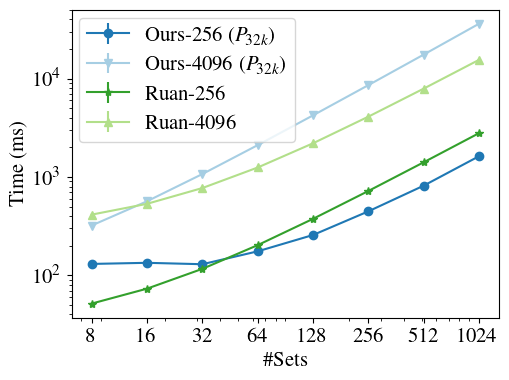

In [17]:
def plot_sd_search(df):
    fig, ax = plt.subplots()

    ax.set_yscale('log')
    ax.set_ylabel('Time (ms)')
    plt.xscale('log')
    ax.set_xlabel('\#Sets')
    ticks = [ 8, 16, 32, 64, 128, 256, 512, 1024]
    plt.xticks(ticks, ticks)

    comp_format = {
        'SD-256' : {
            'label':"Ours-256  ($P_{32k}$)",
            'color':'#1f78b4',
            'fmt':'o-'
        },
        'SD-4k' : {
            'label':"Ours-4096  ($P_{32k}$)",
            'color':'#a6cee3',
            'fmt':'v-'
        },

        'ruan_256' : {
            'label':"Ruan-256",
            'color':'#33a02c',
            'fmt':'*-'
        },
        'ruan_4k' : {
            'label':"Ruan-4096",
            'color':'#b2df8a',
            'fmt':'^-'
        }
    }

    for system in ["SD-256", "SD-4k", "ruan_256","ruan_4k"]:
        df_fil = df[df['system']==system]
        x , y, yerr = df_fil["SetNum"], df_fil['Cost','mean'], df_fil['Cost','sem']
        ax.errorbar(x, y, yerr=yerr, **comp_format[system])

    ax.legend(loc=(0.015, 0.57))

    plt.savefig("sd_ca_small_search.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.show()
plot_sd_search(data_sd)
